#  About Dataset
link https://www.kaggle.com/datasets/alyahmedts13/reddit-sentiment-analysis-dataset-for-nlp-projects/data


This dataset contains short Reddit posts (≤280 characters) about pop music and pop stars, labeled for sentiment analysis.

We collected ~124k posts using keywords like Taylor Swift, Olivia Rodrigo, Grammy, Billboard, and subreddits like popheads, Music, and Billboard. After cleaning and filtering, we kept only short-form, English posts and combined each post’s title and body into a single text column.

The final data set is about 32,000+ rows

Sentiment labels (positive, neutral, negative) were generated using a BERT-based model fine-tuned for social media (CardiffNLP’s Twitter RoBERTa).

This version is ready for NLP sentiment projects — train your own model, explore pop fandom discourse, or benchmark transformer performance on real-world Reddit data.

## Imports

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
import re
import string


import seaborn as sns
import matplotlib.pyplot as plt


# For ML + NLP
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Load The Data

In [2]:
# Download latest version
path = kagglehub.dataset_download("alyahmedts13/reddit-sentiment-analysis-dataset-for-nlp-projects")

print("Path to dataset files:", path)

100%|██████████| 1.15M/1.15M [00:00<00:00, 49.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/alyahmedts13/reddit-sentiment-analysis-dataset-for-nlp-projects/versions/1


In [3]:
print(os.listdir(path))

['reddit_artist_posts_sentiment.csv']


In [4]:
df = pd.read_csv(os.path.join(path,'reddit_artist_posts_sentiment.csv'))

## Explore The Data

In [5]:
df.head()

,text,label
0,pitchfork track review: taylor swift’s “actual...,negative
1,taylor swift has regained the masters of her f...,positive
2,pitchfork review: taylor swift - the life of a...,neutral
3,taylor swift announced engagement,neutral
4,taylor swift - the fate of ophelia (official m...,neutral


In [6]:
df.isna().sum().sum()

np.int64(0)

In [7]:
df.duplicated().sum()

np.int64(1106)

In [8]:
df.shape

(31948, 2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31948 entries, 0 to 31947
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    31948 non-null  object
 1   label   31948 non-null  object
dtypes: object(2)
memory usage: 499.3+ KB


## preprocessing

In [10]:
# we have seen that there is duplicates in the data so we have to take care of those first
# in below code we have drop the duplies and subset = text mean we are watching duplies only in text cols
# and keep only the first occurence and other will drop and index we'll be reset
df = df.drop_duplicates(subset=['text'],keep='first').reset_index(drop=True)

In [11]:
df['label'].value_counts()

,count
label,
neutral,19039
positive,8510
negative,3293


In [12]:
df['label'] = df['label'].replace({"neutral":0,"positive":1,"negative":2})

/tmp/ipython-input-560552202.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace({"neutral":0,"positive":1,"negative":2})


In [13]:
# Clean the text
def clean_text(text):
    text = text.lower()                                         # lowercase

    text = re.sub(r'http\S+|www\S+|https\S+', '', text)         # remove URLs
    text = re.sub(r'<.*?>', '', text)                           # remove HTML tags

    text = re.sub(r'[^a-zA-Z\s]', ' ', text)                    # keep only letters
    # ^ This removes punctuation, symbols, emojis, numbers

    text = re.sub(r'\s+', ' ', text).strip()                    # remove extra spaces

    return text


# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

df[['text', 'clean_text']].head(10)

,text,clean_text
0,pitchfork track review: taylor swift’s “actual...,pitchfork track review taylor swift s actually...
1,taylor swift has regained the masters of her f...,taylor swift has regained the masters of her f...
2,pitchfork review: taylor swift - the life of a...,pitchfork review taylor swift the life of a sh...
3,taylor swift announced engagement,taylor swift announced engagement
4,taylor swift - the fate of ophelia (official m...,taylor swift the fate of ophelia official musi...
5,taylor swift's website launches pre-orders for...,taylor swift s website launches pre orders for...
6,"taylor swift unveils the ""the life of a showgi...",taylor swift unveils the the life of a showgir...
7,taylor swift - the life of a showgirl,taylor swift the life of a showgirl
8,toddintheshadows: pop song review: “the fate o...,toddintheshadows pop song review the fate of o...
9,taylor swift achieves solo artist record 15th ...,taylor swift achieves solo artist record th no...


## Train Test Split

In [14]:
# Features and target
X = df['clean_text']   # cleaned text
y = df['label']        # sentiment labels (positive/negative/neutral)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,        # 20% for testing
    random_state=42,
    stratify=y            # keep same class proportion in train and test
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

print("\nTrain label distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest label distribution:")
print(y_test.value_counts(normalize=True))

Train size: 24673
Test size: 6169

Train label distribution:
label
0    0.617314
1    0.275929
2    0.106756
Name: proportion, dtype: float64

Test label distribution:
label
0    0.617280
1    0.275896
2    0.106824
Name: proportion, dtype: float64


## Build TF-IDF + LinearSVC

In [15]:
model = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=50000,   # keep big vocab
        ngram_range=(1,2),    # unigrams + bigrams boost accuracy
        stop_words='english'  # remove stopwords
    )),
    ('svm', LinearSVC(
        class_weight='balanced'
    ))
])

model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('svm', LinearSVC(class_weight='balanced'))])

## Model Evaluation

In [16]:
y_pred = model.predict(X_test)

In [17]:
print("Accuracy",accuracy_score(y_test,y_pred))

Accuracy 0.7557140541416761


## Classification Report

In [18]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      3808
           1       0.69      0.68      0.68      1702
           2       0.58      0.56      0.57       659

    accuracy                           0.76      6169
   macro avg       0.69      0.69      0.69      6169
weighted avg       0.75      0.76      0.75      6169




Confusion Matrix:
 [[ 366  228   65]
 [ 208 3140  460]
 [  57  489 1156]]


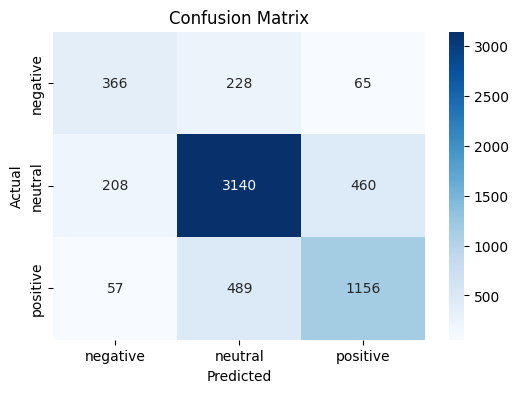

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[2, 0, 1]) # Use numerical labels matching the mapping
print("\nConfusion Matrix:\n", cm)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'],
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## DistilBERT

In [20]:
!pip install -q transformers datasets accelerate


In [21]:
df['label_id'] = df['label']

# Define label mappings for clarity and potential future use, consistent with the existing numerical labels
label_list = ['neutral', 'positive', 'negative'] # Order based on existing numerical mapping (0, 1, 2)
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)} # Also useful to define inverse map

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df[['text', 'label_id']],
    test_size=0.2,
    random_state=42,
    stratify=df['label_id']
)

# Explicitly convert 'label_id' to integer type in both DataFrames
train_df['label_id'] = train_df['label_id'].astype(int)
test_df['label_id'] = test_df['label_id'].astype(int)

## Build HuggingFace Datasets + tokenize

In [22]:
from datasets import Dataset
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create HF Dataset objects
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

# We will rename 'label_id' → 'labels' (what transformers expects)
train_ds = train_ds.rename_column("label_id", "labels")
test_ds  = test_ds.rename_column("label_id", "labels")

# Remove extra index column if present
if "__index_level_0__" in train_ds.column_names:
    train_ds = train_ds.remove_columns("__index_level_0__")
if "__index_level_0__" in test_ds.column_names:
    test_ds = test_ds.remove_columns("__index_level_0__")

# Tokenization function
def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Apply tokenizer
train_ds = train_ds.map(tokenize_batch, batched=True)
test_ds  = test_ds.map(tokenize_batch, batched=True)

# Set format for PyTorch
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/24673 [00:00<?, ? examples/s]

Map:   0%|          | 0/6169 [00:00<?, ? examples/s]

## Define model (DistilBERT for 3-class classification)

In [23]:
import torch
from transformers import AutoModelForSequenceClassification

num_labels = 3

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Handle class imbalance with weighted loss

In [24]:
from collections import Counter
import numpy as np
from torch.nn import CrossEntropyLoss
from transformers import Trainer, TrainingArguments

# Count labels in train set
# Ensure label_id is integer type before counting to get integer keys in Counter
label_counts = Counter(train_df['label_id'].astype(int).tolist())
print("Train label counts:", label_counts)

total = sum(label_counts.values())
class_weights = []

for i in range(num_labels):
    # inverse-frequency style weights
    class_weights.append(total / (num_labels * label_counts[i]))

class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights)


class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # Added **kwargs here
        labels = inputs.get("labels")
        outputs = model(
            input_ids=inputs.get("input_ids"),
            attention_mask=inputs.get("attention_mask")
        )
        logits = outputs.get("logits")
        if self.class_weights is not None:
            loss_fct = CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        else:
            loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                        labels.view(-1))
        return (loss, outputs) if return_outputs else loss

Train label counts: Counter({0: 15231, 1: 6808, 2: 2634})
Class weights: tensor([0.5400, 1.2080, 3.1224])


## Metrics (accuracy + macro F1)

In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)

    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )

    return {
        "accuracy": acc,
        "macro_f1": f1,
        "precision": prec,
        "recall": rec
    }


## TrainingArguments + Trainer

In [26]:
from transformers import DataCollatorWithPadding

training_args = TrainingArguments(
    output_dir="distilbert-sentiment",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=100
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    data_collator=data_collator # Use explicit data collator
)

In [27]:
trainer.train()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yashgamerz0007 (yashgamerz0007-sgu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Precision,Recall
1,0.447700,0.369576,0.836116,0.801483,0.774693,0.852500
2,0.215300,0.438353,0.860107,0.827967,0.812850,0.846005
3,0.158400,0.534164,0.863997,0.834210,0.819797,0.851449


TrainOutput(global_step=4629, training_loss=0.31525120969003056, metrics={'train_runtime': 910.219, 'train_samples_per_second': 81.32, 'train_steps_per_second': 5.086, 'total_flos': 2451319810308864.0, 'train_loss': 0.31525120969003056, 'epoch': 3.0})

## Final evaluation + detailed report

In [28]:
# Evaluate with Trainer
eval_result = trainer.evaluate()
print("Eval metrics:", eval_result)

# Manual predictions for detailed report
pred_output = trainer.predict(test_ds)
y_probs = pred_output.predictions
y_pred = np.argmax(y_probs, axis=1)
y_true = pred_output.label_ids

print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=[id2label[i] for i in range(num_labels)]
))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Eval metrics: {'eval_loss': 0.5341640710830688, 'eval_accuracy': 0.8639974063867726, 'eval_macro_f1': 0.8342100397488271, 'eval_precision': 0.8197972713352321, 'eval_recall': 0.8514487838442456, 'eval_runtime': 22.2423, 'eval_samples_per_second': 277.354, 'eval_steps_per_second': 8.677, 'epoch': 3.0}

Classification Report:
              precision    recall  f1-score   support

     neutral       0.92      0.87      0.89      3808
    positive       0.81      0.88      0.84      1702
    negative       0.73      0.81      0.77       659

    accuracy                           0.86      6169
   macro avg       0.82      0.85      0.83      6169
weighted avg       0.87      0.86      0.87      6169


Confusion Matrix:
[[3299  332  177]
 [ 185 1499   18]
 [ 102   25  532]]
